In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import yaml

In [2]:
## some styling 

plt.style.use('dark_background')

# colors
red    = '#f54242'
orange = '#f7993b'
yellow = '#ffe359'
green  = '#a2f781'
blue   = '#42daf5'
purple = '#d170fa'

# change boxplot
mpl.rcParams['boxplot.boxprops.color'] = blue
mpl.rcParams['boxplot.boxprops.linewidth'] = 1

mpl.rcParams['boxplot.whiskerprops.color'] = blue
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 1

mpl.rcParams['boxplot.medianprops.color'] = blue
mpl.rcParams['boxplot.medianprops.linewidth'] = 1

mpl.rcParams['boxplot.capprops.color'] = blue
mpl.rcParams['boxplot.capprops.linewidth'] = 1

mpl.rcParams['boxplot.flierprops.markeredgecolor'] = red

In [3]:
def remove_impossible_data(df, value_col, lower_limit, upper_limit):
    start_records = len(df)
    df = df[df[value_col] > lower_limit]
    df = df[df[value_col] < upper_limit]
    end_records = len(df)
    print(f'{start_records-end_records} records removed ({(start_records-end_records)/start_records*100:.3f} %)')
    return df


def create_boxplot(data, title, ylabel):

    plt.figure(figsize=(8, 8))
    plt.boxplot(data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()


def create_histogram(data, title, x_label, n_bins):

    plt.figure(figsize=(8, 8))
    plt.hist(data, bins=n_bins, density=True, color=blue)
    plt.xlabel(x_label)
    plt.show()


def create_date_histogram(data, title, n_bins=50):

    plt.figure(figsize=(13, 7))
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    
    date_range = [pd.to_datetime('20150101'), pd.to_datetime('20220101')]

    hist_values, bins, _ = plt.hist(data, bins=n_bins, range=date_range, color=red, width=40)

    # Calculate the centers of the bins
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Fit a linear regression line to the combined histogram values
    z = np.polyfit(bin_centers, hist_values, 1)
    p = np.poly1d(z)

    # Plot the combined trendline
    plt.plot(bin_centers, p(bin_centers), color='white', linestyle='dashed', label='Trendline')

    plt.gcf().autofmt_xdate()
    plt.ylim(0, max(hist_values * 1.2))
    plt.xlim(*date_range)
    plt.grid(alpha=.2)
    plt.show()


def create_pie_diagram(data):
    
    val_counts = data.value_counts()
    color_palettes = plt.colormaps()

    plt.figure(figsize=(8, 8))

    wedges, text, autotexts = plt.pie(val_counts, labels=val_counts.keys(), 
                            autopct='%1.0f%%', labeldistance=1.2, 
                            colors=plt.get_cmap('tab20c').colors)

    plt.setp(autotexts, **{'color':'black', 'weight':'bold', 'fontsize':12.5})
    plt.title('Pie diagram of amount of entries per MEWS score\n', fontsize='18')

    legend_labels = [f'{label} - {percentage:.2f}%' for label, percentage in zip(val_counts.keys(), val_counts / sum(val_counts) * 100)]
    plt.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1))

    plt.tight_layout()
    plt.show()

## Loading the data

In [4]:
with open('./eda_config.yaml') as file:
    config = yaml.safe_load(file)

In [5]:
df = pd.read_csv(config['vital_data'], sep=';')
df['AANKSDATUM'] = pd.to_datetime(df['AANKSDATUM'])
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Value1'] = df['Value1'].str.replace(',', '.')
df['Value1'] = df['Value1'].astype(float)

In [6]:
df.dtypes

SEHID                  int64
PATIENTNR              int64
AANKSDATUM    datetime64[ns]
DateTime      datetime64[ns]
LABEL                 object
Value1               float64
Value2               float64
Value3               float64
EENHEID               object
dtype: object

In [7]:
df_temp = df[df['LABEL'] == 'Temp']
df_hr   = df[df['LABEL'].isin(['HR', 'POLS'])]
df_resp = df[df['LABEL'] == 'Resp']
df_nibp = df[df['LABEL'] == 'NIBP']
df_mews = df[df['LABEL'] == 'MEWS score']

assert sum([len(df_nibp), len(df_resp), len(df_temp), len(df_hr), len(df_mews)]) == len(df)
del df

## Temperature

In [8]:
print(len(df_temp))
print(df_temp.isna().sum())

4635666
SEHID               0
PATIENTNR           0
AANKSDATUM          0
DateTime            0
LABEL               0
Value1            118
Value2        4635666
Value3        4635666
EENHEID             0
dtype: int64


In [9]:
df_temp = df_temp.drop(columns=['Value2', 'Value3'])

In [18]:
df_temp.loc[df_temp['Value1'].isna(), ~df_temp.columns.isin(['SEHID', 'PATIENTNR'])]

,AANKSDATUM,DateTime,LABEL,Value1,EENHEID
149591,2015-03-27,2015-03-27 00:22:04,Temp,NaN,°C
227392,2023-04-16,2023-04-16 19:41:00,Temp,NaN,°C
299643,2021-03-28,2021-03-28 17:25:00,Temp,NaN,°C
484638,2023-01-26,2023-01-26 01:43:00,Temp,NaN,°C
749584,2023-03-08,2023-03-08 18:52:00,Temp,NaN,°C
...,...,...,...,...,...
51275398,2023-03-09,2023-03-09 12:37:00,Temp,NaN,°C
51429269,2023-04-11,2023-04-11 11:35:00,Temp,NaN,°C
51918037,2023-08-19,2023-08-19 11:14:00,Temp,NaN,°C
51920052,2023-07-24,2023-07-24 10:31:00,Temp,NaN,°C


These seem to be missings at random.  
We can delete them.

In [22]:
df_temp = df_temp.dropna()

In [23]:
df_temp = remove_impossible_data(df_temp, 'Value1', 25, 45)

1949866 records removed (42.063 %)


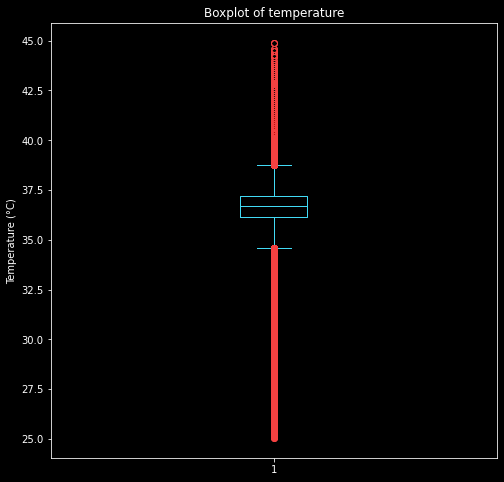

In [24]:
create_boxplot(df_temp['Value1'], 'Boxplot of temperature', 'Temperature (°C)')

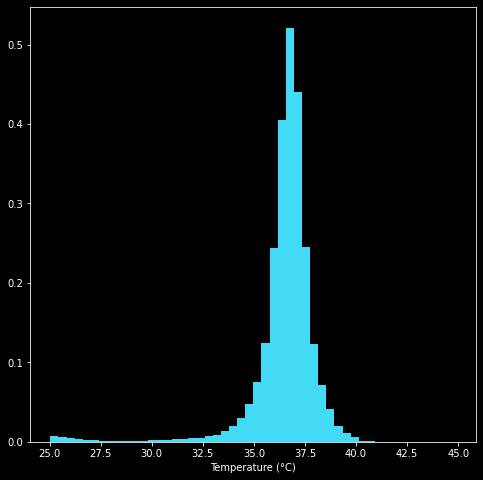

In [25]:
create_histogram(df_temp['Value1'], 'Histogram of temperature', 'Temperature (°C)', 50)

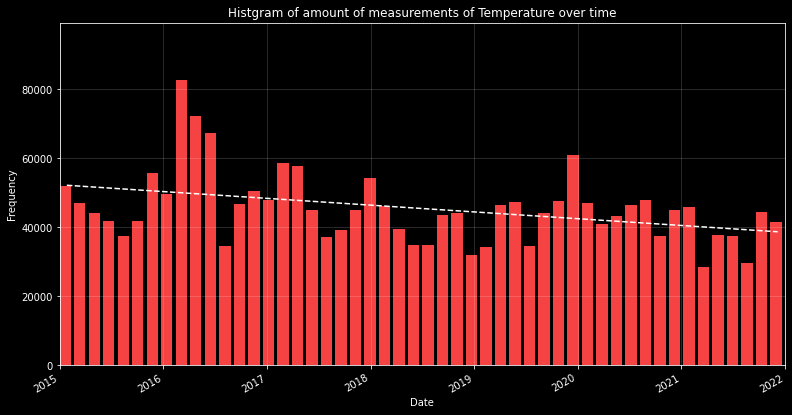

In [26]:
create_date_histogram(df_temp['DateTime'],'Histgram of amount of measurements of Temperature over time')

## Respiratory

In [27]:
print(len(df_resp))
print(df_resp.isna().sum())

11954883
SEHID                0
PATIENTNR            0
AANKSDATUM           0
DateTime             0
LABEL                0
Value1               0
Value2        11954883
Value3        11954883
EENHEID              0
dtype: int64


In [28]:
df_resp = df_resp.drop(columns=['Value2', 'Value3'])

In [29]:
df_resp = remove_impossible_data(df_resp, 'Value1', 3, 50)

96693 records removed (0.809 %)


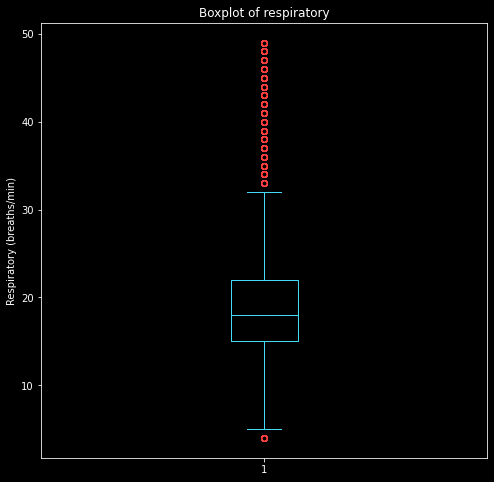

In [30]:
create_boxplot(df_resp['Value1'], 'Boxplot of respiratory', 'Respiratory (breaths/min)')

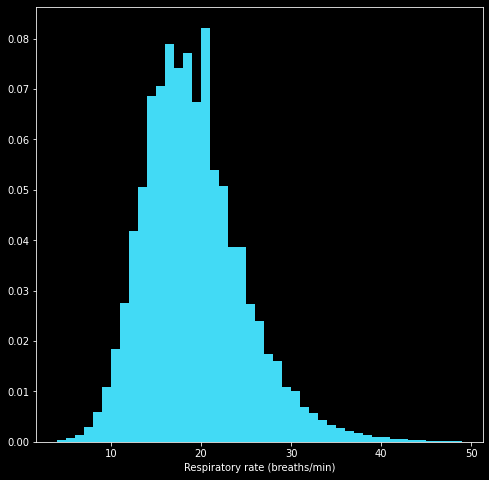

In [31]:
create_histogram(df_resp['Value1'], 'Histogram of respiratory rate', 'Respiratory rate (breaths/min)', 45)

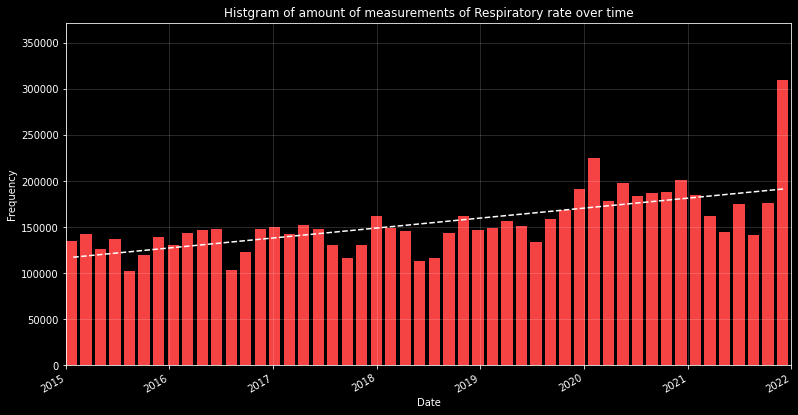

In [32]:
create_date_histogram(df_resp['DateTime'], 'Histgram of amount of measurements of Respiratory rate over time')

## Heart Rate

In [33]:
print(len(df_hr))
print(df_hr.isna().sum())

26583088
SEHID                0
PATIENTNR            0
AANKSDATUM           0
DateTime             0
LABEL                0
Value1             463
Value2        26583087
Value3        26583087
EENHEID              0
dtype: int64


In [34]:
df_hr = df_hr.drop(columns=['Value2', 'Value3'])

In [35]:
df_hr.loc[df_hr['Value1'].isna(), ~df_hr.columns.isin(['SEHID', 'PATIENTNR'])]

,AANKSDATUM,DateTime,LABEL,Value1,EENHEID
263300,2022-02-18,2022-02-18 20:33:51,HR,NaN,bpm
263377,2023-06-27,2023-06-28 12:32:17,HR,NaN,bpm
426167,2019-12-23,2019-12-24 07:40:37,HR,NaN,bpm
426168,2019-12-23,2019-12-24 11:53:46,HR,NaN,bpm
496854,2021-04-18,2021-04-19 08:20:47,HR,NaN,bpm
...,...,...,...,...,...
51924220,2023-08-09,2023-08-10 08:16:00,HR,NaN,bpm
52020906,2023-07-25,2023-07-26 10:55:01,HR,NaN,bpm
52052333,2023-07-24,2023-07-25 12:14:59,HR,NaN,bpm
52110837,2023-08-02,2023-08-02 22:51:16,HR,NaN,bpm


In [36]:
df_hr = df_hr[df_hr['Value1'].notna()]

In [37]:
df_hr = remove_impossible_data(df_hr, 'Value1', 30, 200)

24844 records removed (0.093 %)


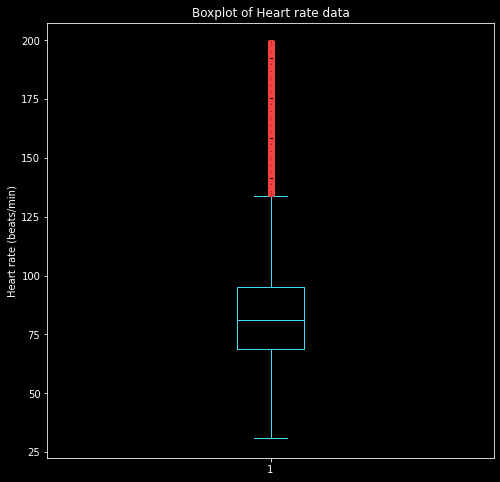

In [38]:
create_boxplot(df_hr['Value1'], 'Boxplot of Heart rate data', 'Heart rate (beats/min)')

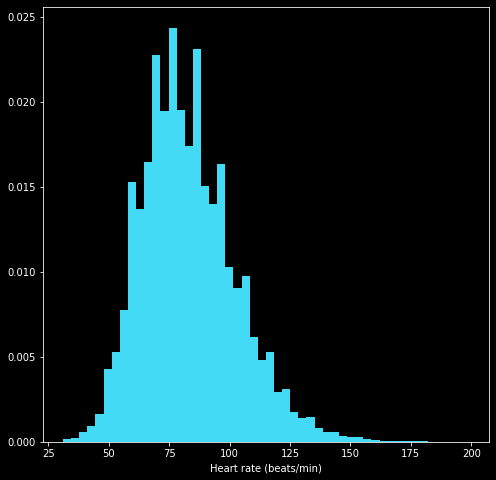

In [39]:
create_histogram(df_hr['Value1'], 'Boxplot of Heart rate data', 'Heart rate (beats/min)', 50)

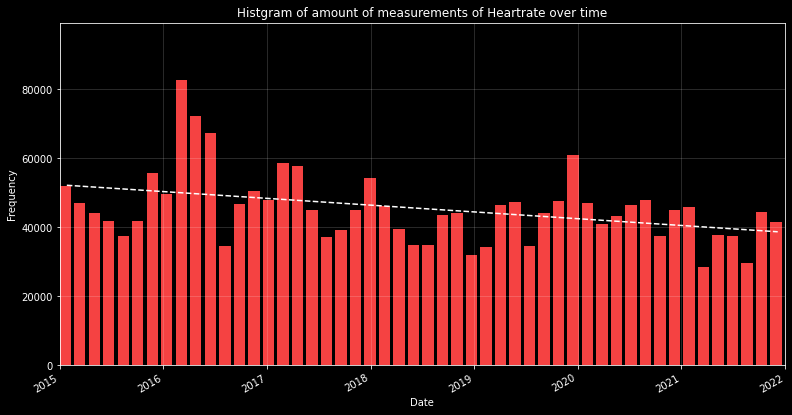

In [40]:
create_date_histogram(df_temp['DateTime'], 'Histgram of amount of measurements of Heartrate over time')

## Blood pressure

In [41]:
print(len(df_nibp))
print(df_nibp.isna().sum())

8933195
SEHID             0
PATIENTNR         0
AANKSDATUM        0
DateTime          0
LABEL             0
Value1        28397
Value2        28890
Value3         5864
EENHEID           0
dtype: int64


In [42]:
df_nibp = df_nibp.dropna()

In [43]:
def mbp(sbp, dbp):
    return round(dbp + (1/3) * (sbp - dbp))

In [44]:
df_nibp = remove_impossible_data(df_nibp, 'Value1', 50, 250)  # systolic
df_nibp = remove_impossible_data(df_nibp, 'Value2', 10, 150)  # dyastollic

11022 records removed (0.124 %)
12246 records removed (0.138 %)


### Systollic blood pressure

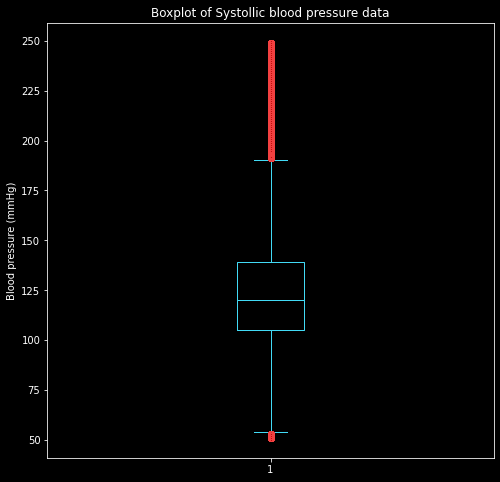

In [45]:
create_boxplot(df_nibp['Value1'], 'Boxplot of Systollic blood pressure data', 'Blood pressure (mmHg)')

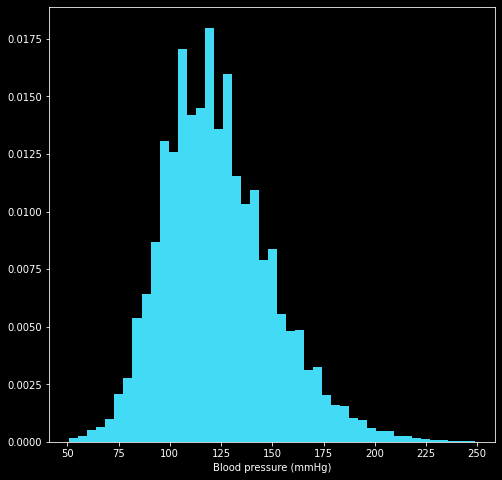

In [46]:
create_histogram(df_nibp['Value1'], 'Boxplot of Systollic blood pressure data', 'Blood pressure (mmHg)', 45)

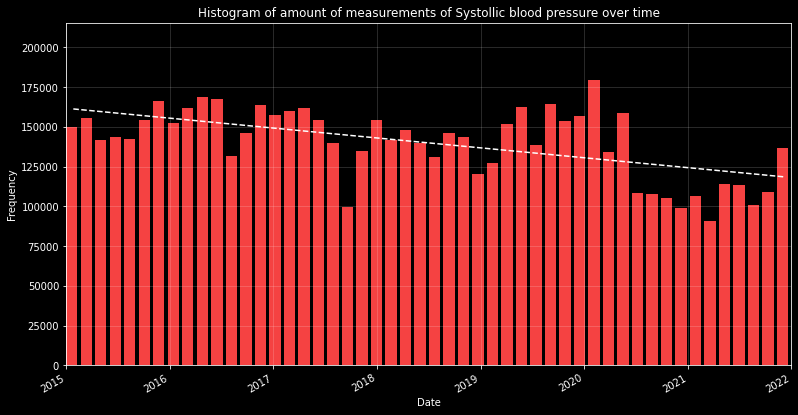

In [47]:
create_date_histogram(df_nibp['DateTime'], 'Histogram of amount of measurements of Systollic blood pressure over time')

### Dialstollic blood pressure

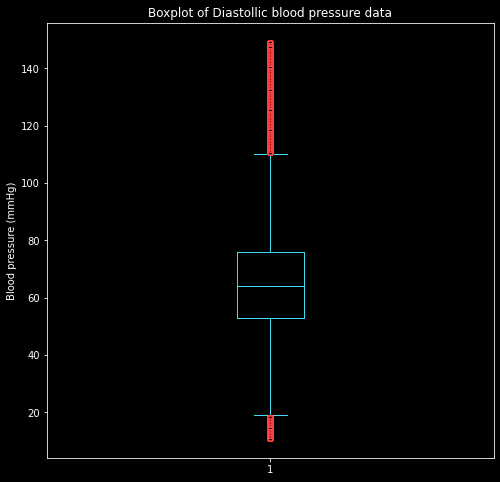

In [48]:
create_boxplot(df_nibp['Value2'], 'Boxplot of Diastollic blood pressure data', 'Blood pressure (mmHg)')

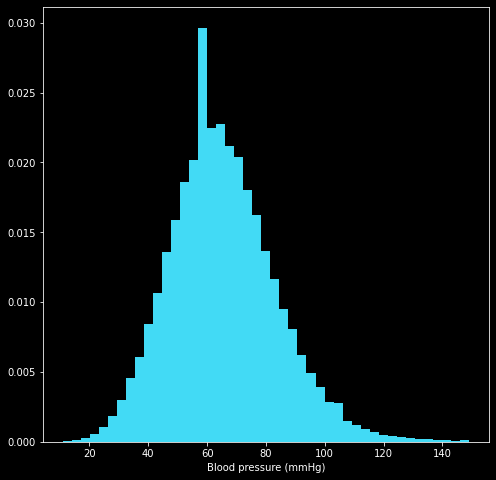

In [49]:
create_histogram(df_nibp['Value2'], 'Boxplot of Diastollic blood pressure data', 'Blood pressure (mmHg)', 45)

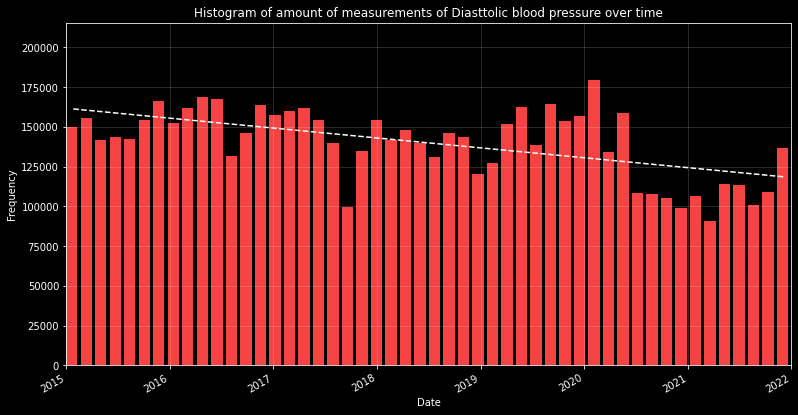

In [50]:
create_date_histogram(df_nibp['DateTime'], 'Histogram of amount of measurements of Diasttolic blood pressure over time')
# Histogram is the same is systollic as the blood pressure are always measured together 

## MEWS Score

In [51]:
print(len(df_hr))
print(df_hr.isna().sum())

26557781
SEHID         0
PATIENTNR     0
AANKSDATUM    0
DateTime      0
LABEL         0
Value1        0
EENHEID       0
dtype: int64


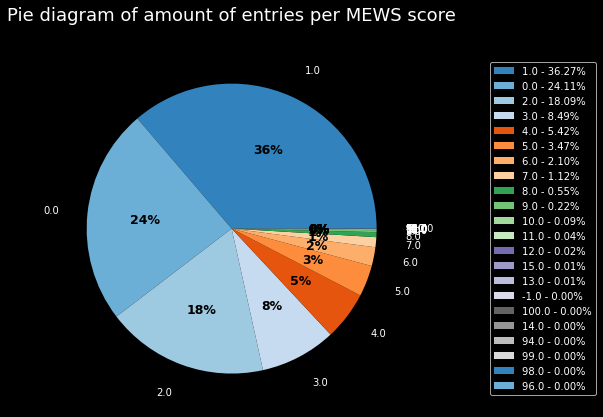

In [52]:
create_pie_diagram(df_mews['Value1'])

MEWS score ranges from 0 to 3, all other values are invalid.   
We need to remove these.

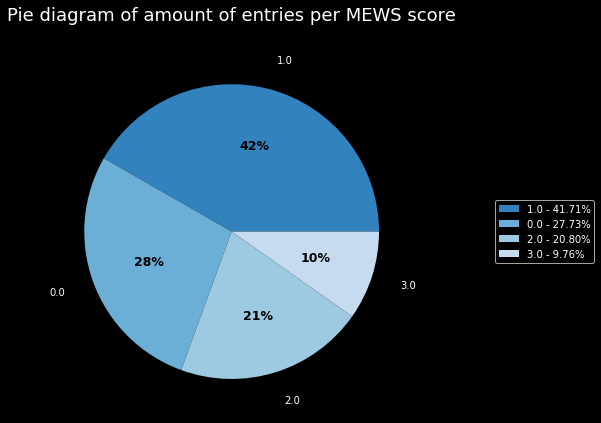

In [53]:
df_mews = df_mews[df_mews['Value1'].isin(range(4))]
create_pie_diagram(df_mews['Value1'])

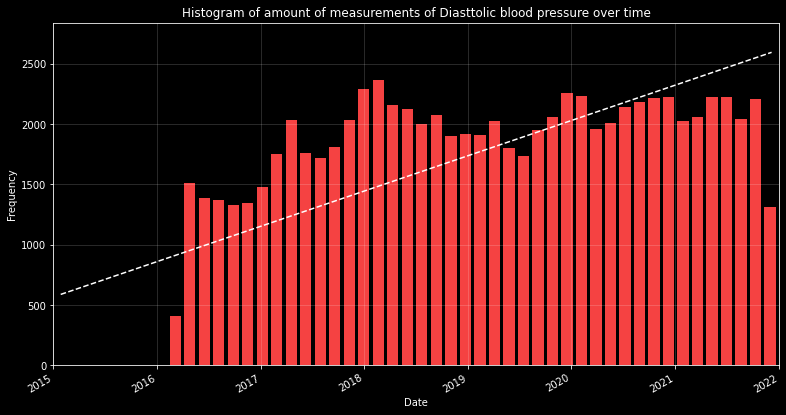

In [54]:
create_date_histogram(df_mews['DateTime'], 'Histogram of amount of measurements of Diasttolic blood pressure over time')

In [57]:
df_mews.sort_values('DateTime').loc[:,~df_mews.columns.isin(['SEHID', 'PATIENTNR'])]

,AANKSDATUM,DateTime,LABEL,Value1,Value2,Value3,EENHEID
15585870,2015-12-27,2015-12-27 23:56:00,MEWS score,1.0,NaN,NaN,NaN
533988,2016-01-06,2016-01-06 01:07:00,MEWS score,1.0,NaN,NaN,NaN
15956243,2016-01-10,2016-01-10 19:48:00,MEWS score,3.0,NaN,NaN,NaN
10415155,2016-01-25,2016-01-25 09:32:00,MEWS score,3.0,NaN,NaN,NaN
25468539,2016-03-12,2016-03-12 06:21:00,MEWS score,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
48504959,2023-10-02,2023-10-02 22:08:00,MEWS score,0.0,NaN,NaN,NaN
51654814,2023-10-02,2023-10-02 22:28:00,MEWS score,1.0,NaN,NaN,NaN
12248336,2023-10-02,2023-10-02 23:51:00,MEWS score,1.0,NaN,NaN,NaN
48514090,2023-10-02,2023-10-03 00:35:00,MEWS score,2.0,NaN,NaN,NaN


They actually start using MEWS score from end 2015 / beginning 2016.